In [1]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [ ]:
# get input data
deepmimo = True

function_folder = "seq_sin_pink_-2.51"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

             0          1          2         3         4          5         6  \
0     1.645583  -3.315203   1.570012  2.722560 -2.219355  -3.322635 -3.100562   
1    -1.480088  -4.529358  -2.598992 -3.089643 -0.611498  -0.002096 -6.257159   
2    -0.780961  -0.773112  -1.521602 -3.001004 -6.766938  -3.764125 -2.019509   
3    -3.928181  -2.294532  -1.618823  0.013272 -3.834938   4.227398  4.975426   
4    -3.374270  -6.541037  -7.001241 -7.142429 -0.059697  -1.888985 -0.454449   
..         ...        ...        ...       ...       ...        ...       ...   
695   3.293489  -7.660050 -10.909821 -3.837664  1.436104   5.779468 -5.969749   
696  14.024460  11.906965   6.604996  6.319699  6.146773  11.805930  0.060076   
697   0.123793   7.353714   6.703714  0.824722  3.220820   6.790443  2.925328   
698   2.732842  -1.860174  -1.856970  5.656293 -4.830445  -1.857152 -3.855314   
699   5.199776   3.156008  -9.578371 -3.253810 -2.085479  -0.847889 -0.687449   

            7         8    

In [3]:
print(type(data))

<class 'convert_data_to_input.CreateInput'>


In [4]:
tensors['test'][1].shape

torch.Size([200, 30])

# Evaluate KAN

In [5]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)
input_size = tensors['test'][1].shape[1]

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[input_size, 2*input_size + 1, input_size],
                       [input_size, 20, input_size], [input_size, 20, 20, input_size], [input_size, 20, 20, 20, input_size],
                       [input_size, 10, input_size],
                       [input_size, 5, input_size],
                       [input_size, 20, 10, 20, input_size], [input_size, 10, 5, 10, input_size]], 
        'kan__grid': [3, 5],
        'kan__k': [3, 5],
        'kan__seed': [42],
        'kan__lr': [0.01],
        'kan__lamb': [0],
        'kan__deepmimo': [True],
        'kan__epochs': [10]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1, 3, 1], [1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 3, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [20]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['kan__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


Fitting 5 folds for each of 32 candidates, totalling 160 fits


| train_loss: 2.58e-03 | test_loss: 6.51e-01 | reg: 3.17e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it
| train_loss: 2.74e-03 | test_loss: 6.78e-01 | reg: 3.18e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/
| train_loss: 2.62e-03 | test_loss: 6.80e-01 | reg: 3.16e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/
| train_loss: 2.79e-03 | test_loss: 6.46e-01 | reg: 3.19e+01 | : 100%|█| 10/10 [00:10<00:00,  1.01s/
| train_loss: 2.62e-03 | test_loss: 6.60e-01 | reg: 3.15e+01 | : 100%|█| 10/10 [00:10<00:00,  1.04s/
| train_loss: 1.90e-03 | test_loss: 5.21e-01 | reg: 7.08e+01 | : 100%|█| 10/10 [00:14<00:00,  1.46s/
| train_loss: 1.70e-03 | test_loss: 5.15e-01 | reg: 6.95e+01 | : 100%|█| 10/10 [00:14<00:00,  1.48s/
| train_loss: 1.75e-03 | test_loss: 5.10e-01 | reg: 6.92e+01 | : 100%|█| 10/10 [00:13<00:00,  1.32s/
| train_loss: 1.67e-03 | test_loss: 5.09e-01 | reg: 7.01e+01 | : 100%|█| 10/10 [00:13<00:00,  1.30s/
| train_loss: 1.64e-03 | test_loss: 5.14e-01 | reg: 6.95e+01 | : 100%|█| 10/10 [00:13<00:00

Best Parameters: {'kan__data': [], 'kan__deepmimo': True, 'kan__epochs': 10, 'kan__grid': 3, 'kan__k': 3, 'kan__lamb': 0, 'kan__lr': 0.01, 'kan__seed': 42, 'kan__width': [[30, 0], [20, 0], [20, 0], [30, 0]]}
Best Cross-Validation Score: -4.100951682630694e-05


In [6]:
# evaluate KAN with optimal params
kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=30, results_path=f'results/KAN/{function_folder}')
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.23e-04 | test_loss: 7.35e-04 | reg: 3.97e+01 | : 100%|█| 30/30 [00:13<00:00,  2.24it

saving model version 0.1


In [7]:
"""print(y_preds['preds'][0].shape)
x=np.linspace(-10, 10, 20)
many_x = np.linspace(-10, 10, 200)
plt.plot(x, y_preds['preds'][0], "o")
plt.plot(many_x, np.sin(many_x))
plt.plot(x, tensors['train'][0][0], ".")
plt.show()"""

'print(y_preds[\'preds\'][0].shape)\nx=np.linspace(-10, 10, 20)\nmany_x = np.linspace(-10, 10, 200)\nplt.plot(x, y_preds[\'preds\'][0], "o")\nplt.plot(many_x, np.sin(many_x))\nplt.plot(x, tensors[\'train\'][0][0], ".")\nplt.show()'

In [8]:
"""if deepmimo:
    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()"""

'if deepmimo:\n    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)\n    kan_model.load_data(tensors)\n    loss_data, time_elapsed = kan_model.fit()\n    y_preds = kan_model.predict()'

torch.Size([30])
30


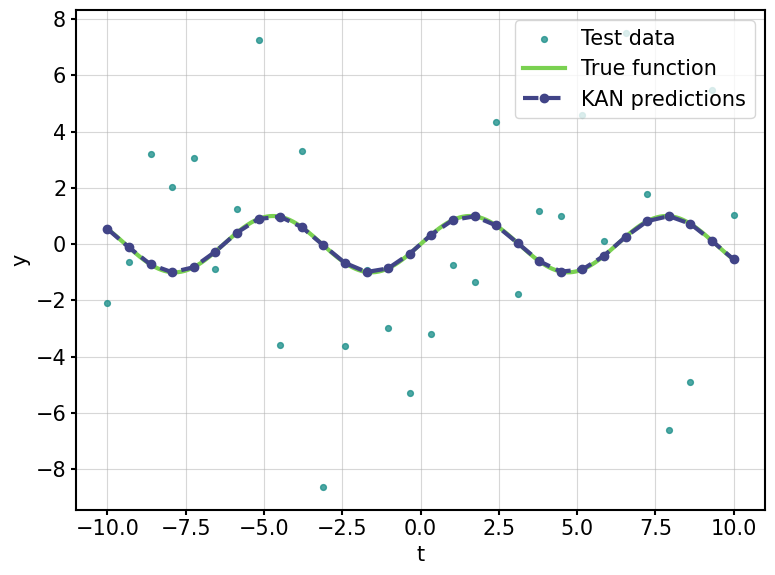

In [9]:
# plot pred and true
if deepmimo:
    #kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
    kan_model.plot_sequence(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)

In [10]:
# plot noise and true
# if deepmimo:
#     kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=False)

In [11]:
# diffrence in noise and true
#torch.sum(np.abs(tensors['test'][0][:1,:] - tensors['test'][1][:1,:]))

In [12]:
# diffrence pred and true
#torch.sum(np.abs(y_preds['preds'][0] - tensors['test'][1][:1,:]))

saved loss to  results/KAN/seq_sin_pink_-16.47/loss.png
Model parameters saved to results/KAN/seq_sin_pink_-16.47/model_params.txt


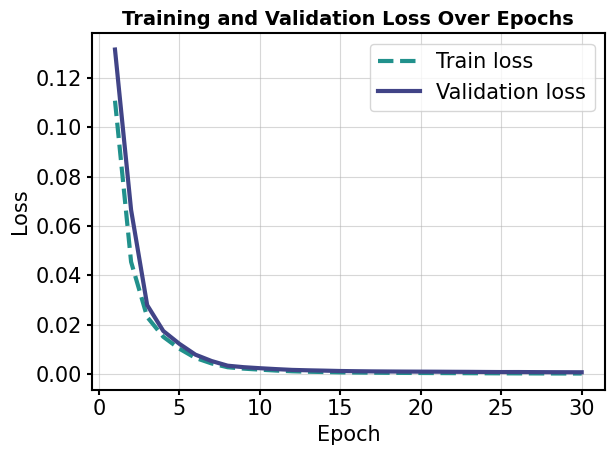

In [13]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=True)

In [14]:
# Test loss
print(y_preds['test_loss'])

tensor(0.0018)


# Evaluate MLP

In [15]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [input_size],
        'mlp__hidden_size': [[2*input_size + 1],
                       [20], [20, 20], [20, 20, 20],
                       [10],
                       [5],
                       [20, 10, 20], [10, 5, 10]],
        'mlp__output_size': [input_size],
        'mlp__epochs': [10],
        'mlp__deepmimo': [True],
        'mlp__lr': [0.01]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20, 21],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)"""

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


100%|██████████| 10/10 [00:00<00:00, 91.44it/s]

Best Parameters: {'mlp__data': [], 'mlp__deepmimo': True, 'mlp__epochs': 10, 'mlp__hidden_size': [5], 'mlp__input_size': 30, 'mlp__lr': 0.01, 'mlp__output_size': 30}
Best Cross-Validation Score: -5.062657034015928e-06


In [16]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'], result_path=f'results/MLP/{function_folder}')
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=30, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

100%|██████████| 30/30 [00:00<00:00, 54.73it/s]


torch.Size([30])
30


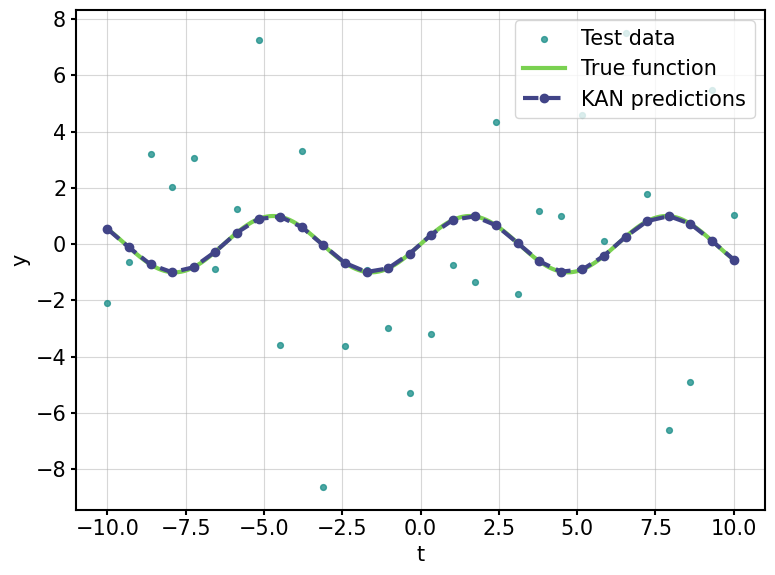

In [17]:
# plot predictions
if deepmimo:
    # mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
    mlp_model.plot_sequence(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)

saved loss to  results/MLP/seq_sin_pink_-16.47/loss.png
Model parameters saved to results/MLP/seq_sin_pink_-16.47/model_params.txt


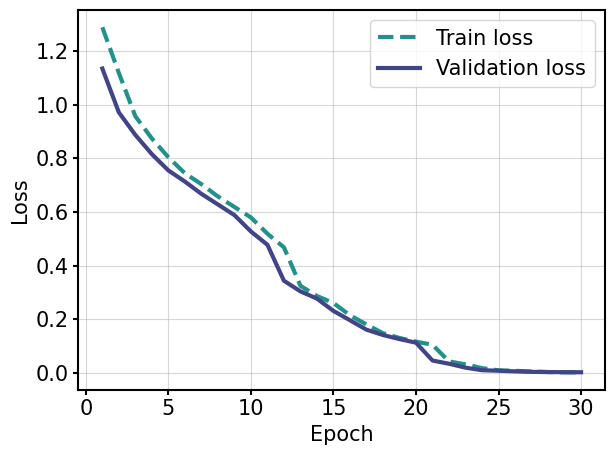

In [18]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=True, deepmimo=deepmimo)

In [19]:
# Test loss
print(y_preds_MLP['test_loss'])

tensor(0.0034)
